In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random


# Load Dataset

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dnyaneshwalwadkar/fingerprintdata-npz")

print("Path to dataset files:", path)


100%|██████████| 210M/210M [00:01<00:00, 151MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dnyaneshwalwadkar/fingerprintdata-npz/versions/1


(6000, 90, 90, 1) (6000, 4)


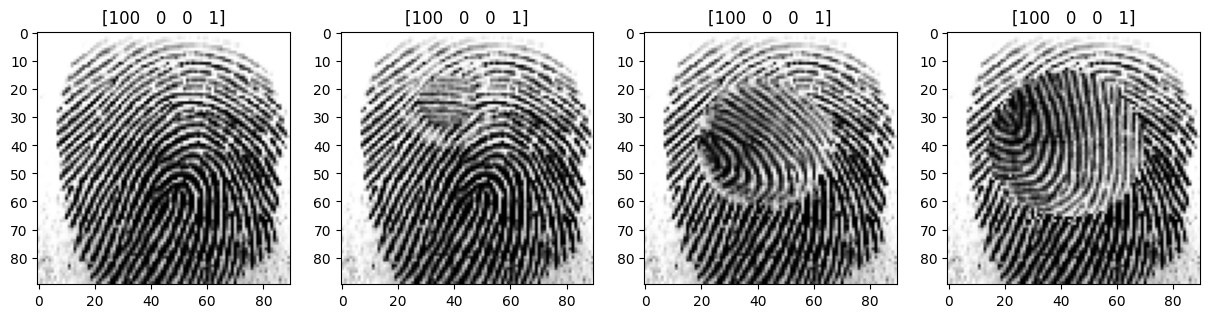

In [ ]:
x_real = np.load(path+'/dataset/x_real.npz')['data']
y_real = np.load(path+'/dataset/y_real.npy')
x_easy = np.load(path+'/dataset/x_easy.npz')['data']
y_easy = np.load(path+'/dataset/y_easy.npy')
x_medium = np.load(path+'/dataset/x_medium.npz')['data']
y_medium = np.load(path+'/dataset/y_medium.npy')
x_hard = np.load(path+'/dataset/x_hard.npz')['data']
y_hard = np.load(path+'/dataset/y_hard.npy')

print(x_real.shape, y_real.shape)

plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title(y_real[0])
plt.imshow(x_real[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 2)
plt.title(y_easy[0])
plt.imshow(x_easy[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 3)
plt.title(y_medium[0])
plt.imshow(x_medium[0].squeeze(), cmap='gray')
plt.subplot(1, 4, 4)
plt.title(y_hard[0])
plt.imshow(x_hard[0].squeeze(), cmap='gray')


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()


True

# Train Test Split

In [ ]:
x_data = np.concatenate([x_easy, x_medium, x_hard], axis=0)
label_data_ = np.concatenate([y_easy, y_medium, y_hard], axis=0)

print(label_data_[:,0])#subject_id(1-600)

unique_values = np.unique(label_data_[:, 0])
print(unique_values)

label_data= label_data_[:,0] -1
print(np.unique(label_data))#subject_id(0-599)

x_train, x_temp, label_train, label_temp = train_test_split(x_data, label_data, test_size=0.2, shuffle=True, random_state=41)


x_val, x_test, label_val, label_test = train_test_split(x_temp, label_temp, test_size=0.5, shuffle=True, random_state=41)


print(f"Total data: {x_data.shape}, {label_data.shape}")
print(f"Train: {x_train.shape}, {label_train.shape}")
print(f"Validation: {x_val.shape}, {label_val.shape}")
print(f"Test: {x_test.shape}, {label_test.shape}")


[100 100 100 ...   9   9   9]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 

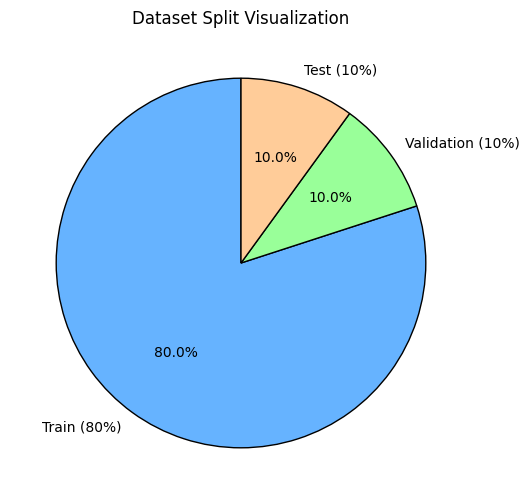

In [ ]:
# Step 4: Create a Pie Chart to Show Data Split
sizes = [len(x_train), len(x_val), len(x_test)]
labels = ["Train (80%)", "Validation (10%)", "Test (10%)"]
colors = ['#66b3ff','#99ff99','#ffcc99']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title("Dataset Split Visualization")
plt.show()


In [ ]:
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
import torchvision.transforms.functional as F

weights = EfficientNet_B4_Weights.DEFAULT


# Data Generator

In [ ]:
pre_trans = weights.transforms()
pre_trans


ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, x_data, label_data):
        self.x_data = x_data
        self.label_data = label_data


    def __getitem__(self, idx):
        image = F.to_pil_image(self.x_data[idx].squeeze())
        image = image.convert('RGB')
        image = pre_trans(image).to(device)
        label = torch.tensor(self.label_data[idx], dtype=torch.long).to(device)
        return image, label

    def __len__(self):
        return len(self.x_data)

In [ ]:
# Create instances of MyDataset for training and validation
train_data = MyDataset(x_train, label_train)
val_data = MyDataset(x_val, label_val)
# Create DataLoader for training data
BATCH_SIZE = 32
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

train_N = len(train_loader.dataset)
valid_N = len(val_loader.dataset)

for batch_x, batch_y in train_loader:
    print(batch_x.shape, batch_y.shape)  #shapes of a batch
    break


torch.Size([32, 3, 380, 380]) torch.Size([32])


In [ ]:
test_data = MyDataset(x_test, label_test)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
test_N = len(test_loader.dataset)

# Create Model

In [ ]:
model = efficientnet_b4(weights=weights)
N_CLASSES = 600
for param in model.features.parameters():
    param.requires_grad = False
for param in model.features[8:].parameters():
    param.requires_grad = True
model.classifier = nn.Sequential(
    nn.Linear(model.classifier[1].in_features, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(1024, N_CLASSES)
)
model.to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-23ab8bcd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-23ab8bcd.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 185MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [ ]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 112, 112]           1,296
       BatchNorm2d-2         [-1, 48, 112, 112]              96
              SiLU-3         [-1, 48, 112, 112]               0
            Conv2d-4         [-1, 48, 112, 112]             432
       BatchNorm2d-5         [-1, 48, 112, 112]              96
              SiLU-6         [-1, 48, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 48, 1, 1]               0
            Conv2d-8             [-1, 12, 1, 1]             588
              SiLU-9             [-1, 12, 1, 1]               0
           Conv2d-10             [-1, 48, 1, 1]             624
          Sigmoid-11             [-1, 48, 1, 1]               0
SqueezeExcitation-12         [-1, 48, 112, 112]               0
           Conv2d-13         [-1, 24, 112, 112]           1,152
      BatchNorm2d-14         [-1, 24, 1

In [ ]:
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N
def train(model, train_loader, train_N, optimizer, loss_function):
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

def validate(model, valid_loader, valid_N, loss_function):
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))


In [ ]:
from torch.optim import Adam
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

def get_batch_predictions(output):
    return output.argmax(dim=1)

def train(model, train_loader, train_N, optimizer, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        total_loss += batch_loss.item()
        total_correct += (get_batch_predictions(output) == y).sum().item()

        all_preds.extend(get_batch_predictions(output).cpu().numpy())
        all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / train_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['train_loss'].append(avg_loss)
    metrics_history['train_accuracy'].append(accuracy)
    metrics_history['train_precision'].append(precision)
    metrics_history['train_recall'].append(recall)
    metrics_history['train_f1'].append(f1)

    print('Train - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))


def validate(model, valid_loader, valid_N, loss_function, metrics_history):
    total_loss = 0
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)
            total_loss += loss_function(output, y).item()
            total_correct += (get_batch_predictions(output) == y).sum().item()

            all_preds.extend(get_batch_predictions(output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    avg_loss = total_loss / len(valid_loader)
    accuracy = total_correct / valid_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    metrics_history['valid_loss'].append(avg_loss)
    metrics_history['valid_accuracy'].append(accuracy)
    metrics_history['valid_precision'].append(precision)
    metrics_history['valid_recall'].append(recall)
    metrics_history['valid_f1'].append(f1)

    print('Valid - Loss: {:.4f} Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(
        avg_loss, accuracy, precision, recall, f1))

def plot_metrics(metrics_history):
    epochs = range(1, len(metrics_history['train_accuracy']) + 1)

    #Plot Loss
    plt.figure(figsize=(10, 9))
    plt.subplot(3, 2, 1)
    plt.plot(epochs, metrics_history['train_loss'], label='Train Loss')
    plt.plot(epochs, metrics_history['valid_loss'], label='Valid Loss')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss vs Epochs')
    # Plot Recall
    plt.subplot(3, 2, 2)
    plt.plot(epochs, metrics_history['train_recall'], label='Train Recall')
    plt.plot(epochs, metrics_history['valid_recall'], label='Valid Recall')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall vs Epochs')

    # Plot Accuracy
    plt.subplot(3, 2, 3)
    plt.plot(epochs, metrics_history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, metrics_history['valid_accuracy'], label='Valid Accuracy')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Epochs')

    # Plot Precision
    plt.subplot(3, 2, 4)
    plt.plot(epochs, metrics_history['train_precision'], label='Train Precision')
    plt.plot(epochs, metrics_history['valid_precision'], label='Valid Precision')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision vs Epochs')

    # Plot F1-Score
    plt.subplot(3, 2, 5)
    plt.plot(epochs, metrics_history['train_f1'], label='Train F1-Score')
    plt.plot(epochs, metrics_history['valid_f1'], label='Valid F1-Score')
    plt.xticks(np.arange(0, 21, 2))
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.legend()
    plt.title('F1-Score vs Epochs')

    plt.tight_layout()
    plt.show()

In [ ]:
metrics_history = {
    'train_loss': [],
    'train_accuracy': [],
    'train_precision': [],
    'train_recall': [],
    'train_f1': [],
    'valid_loss': [],
    'valid_accuracy': [],
    'valid_precision': [],
    'valid_recall': [],
    'valid_f1': [],
}


# Train and Evaluation

In [ ]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train(model, train_loader, train_N, optimizer, loss_function,metrics_history)
    validate(model, val_loader, valid_N, loss_function,metrics_history)



Epoch: 0
Train - Loss: 5.5013 Accuracy: 0.0738 Precision: 0.0777 Recall: 0.0738 F1-Score: 0.0634
Valid - Loss: 4.4685 Accuracy: 0.2488 Precision: 0.3675 Recall: 0.2488 F1-Score: 0.2254
Epoch: 1
Train - Loss: 4.0766 Accuracy: 0.2775 Precision: 0.2904 Recall: 0.2775 F1-Score: 0.2565
Valid - Loss: 3.3221 Accuracy: 0.4719 Precision: 0.5811 Recall: 0.4719 F1-Score: 0.4590
Epoch: 2
Train - Loss: 3.1225 Accuracy: 0.4507 Precision: 0.4621 Recall: 0.4507 F1-Score: 0.4373
Valid - Loss: 2.4316 Accuracy: 0.6247 Precision: 0.7037 Recall: 0.6247 F1-Score: 0.6196
Epoch: 3
Train - Loss: 2.3843 Accuracy: 0.5817 Precision: 0.5895 Recall: 0.5817 F1-Score: 0.5742
Valid - Loss: 1.7675 Accuracy: 0.7359 Precision: 0.7873 Recall: 0.7359 F1-Score: 0.7332
Epoch: 4
Train - Loss: 1.8437 Accuracy: 0.6761 Precision: 0.6794 Recall: 0.6761 F1-Score: 0.6723
Valid - Loss: 1.3304 Accuracy: 0.8052 Precision: 0.8410 Recall: 0.8052 F1-Score: 0.8044
Epoch: 5
Train - Loss: 1.4320 Accuracy: 0.7477 Precision: 0.7499 Recall: 0.

In [ ]:
torch.save(model.state_dict(), 'eff_model.pth2')

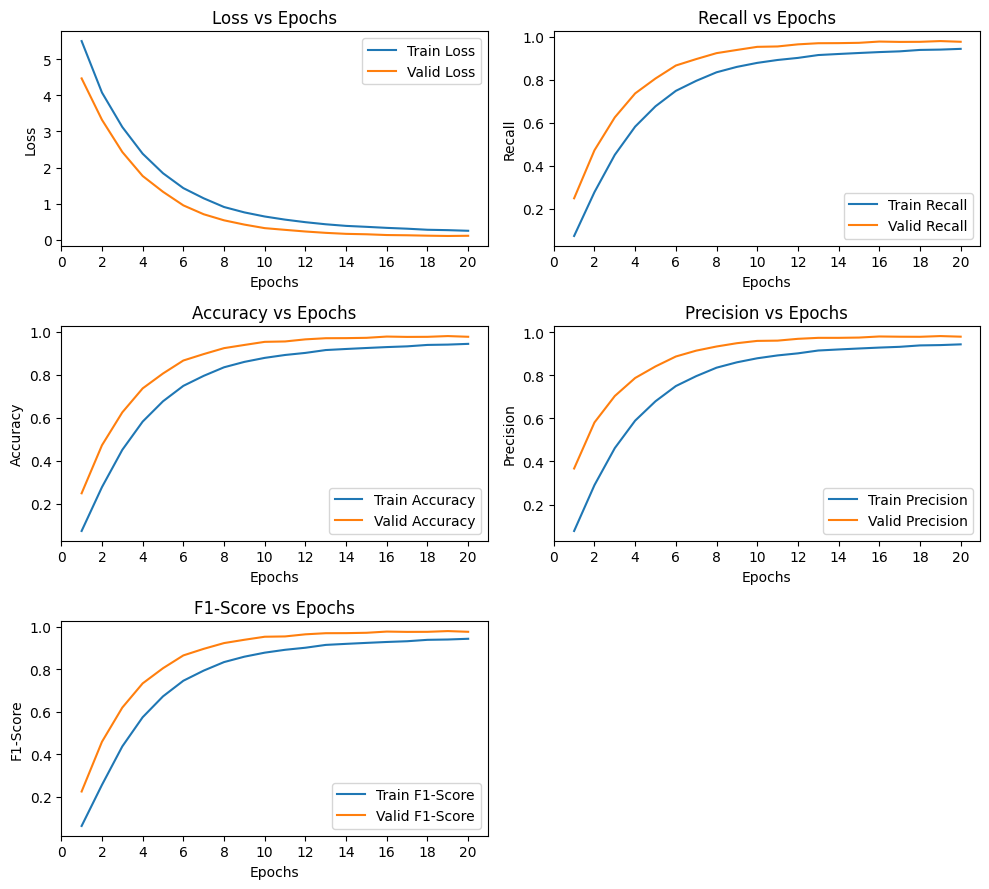

In [ ]:
plot_metrics(metrics_history)

In [ ]:
def test(model, test_loader, test_N):
    total_correct = 0
    all_preds = []
    all_targets = []

    model.eval()
    with torch.no_grad():
        for x, y in test_loader:
            output = model(x)
            total_correct += (get_batch_predictions(output) == y).sum().item()

            all_preds.extend(get_batch_predictions(output).cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    accuracy = total_correct / test_N
    precision = precision_score(all_targets, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='weighted', zero_division=0)

    print('Test - Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1-Score: {:.4f}'.format(accuracy, precision, recall, f1))

In [ ]:
test(model, test_loader, test_N)

Test - Accuracy: 0.9756 Precision: 0.9793 Recall: 0.9756 F1-Score: 0.9756
